### Library 

In [41]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats

path_main_folder = '/home/restor/partage/apogee-parades/AED_autoencoder'

sys.path.append(path_main_folder)

from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE_temp, CVAE
from conso.load_shape_data import *  
from Visualisation.buildProjector import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

## Recette pour apprendre un bon autoencoder conditionnel
Apres avoir augmenté le nombre de couches, inséré des sigmoids proches de l'espace latent de l'autoencoder, donner plus de poids à la loss de reconstruction (cf référence d'Antoine Rosin sur l'over pruning), et augmenter l'apprentissage, on atteint une loss de reconstruction de l'ordre de 0.4 qui donne de bons résultats et de belles projections!
On peut augmenter l'importance de la KL loss mais le temps d'apprentissage doit être augmenté (1000 pour beta=0.01 vs 500 pour beta=0.01.
Question: souhaite-t-on un espace très gaussien dans toutes les directions ? Ce serait intéressant si l'on souhaite générer des courbes de conso. Mais si l'on souhaite explorer l'espace latent, cela peut-être une contrainte potentiellement trop forte

A vérifier mais plus on passe de conditions, plus la loss de reconstruction devrait diminuer.

In [42]:
#un code pour n'afficher que quelques resultats pendant l'entrainement de l'autoencoder

nbsample=20
from keras.callbacks import TensorBoard
from keras.callbacks import Callback

class NEpochLogger(Callback):
    def __init__(self, display):
        self.seen = 0
        self.display = display

    def on_epoch_end(self, epoch, logs={}):
        self.seen += logs.get('size', 0)
        if epoch % self.display == 0:
            metrics_log = ''
            for k in self.params['metrics']:
                if k in logs:
                    val = logs[k]
                    if abs(val) > 1e-3:
                        metrics_log += ' - %s: %.4f' % (k, val)
                    else:
                        metrics_log += ' - %s: %.4e' % (k, val)
            print('{} Epochs ... {}'.format(epoch, metrics_log))

### Load and shape data 

In [43]:
# Load raw data
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

In [44]:
# Load Holiday day information
holiday_days_csv = os.path.join(path_data, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

In [45]:
# Unifomization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

In [46]:
# Change ganularity ?
name_granu = '30m'#'1H'
data_conso_df = change_granularity(data_conso_df, granularity="30min") #1H"

In [47]:
data_conso_df.head(5)

,ds,conso_nat_t0,002Th+0,005Th+0,015Th+0,027Th+0,070Th+0,110Th+0,120Th+0,130Th+0,...,630Th+0,643Th+0,645Th+0,650Th+0,675Th+0,690Th+0,747Th+0,meteo_natTh+0,type_tempo,is_holiday_day
0,2012-12-28 00:00:00,59679.0,7.7,7.90,7.2,7.10,6.40,11.30,8.70,9.10,...,10.90,13.00,11.40,11.4,13.20,14.20,15.2,8.857143,NaN,0.0
1,2012-12-28 00:30:00,58103.0,7.6,7.80,7.2,7.55,6.80,11.40,9.05,9.05,...,10.90,11.45,10.95,11.1,12.95,13.90,14.7,8.764286,NaN,0.0
2,2012-12-28 01:00:00,55354.0,7.5,7.70,7.2,8.00,7.20,11.50,9.40,9.00,...,10.90,9.90,10.50,10.8,12.70,13.60,14.2,8.671429,NaN,0.0
3,2012-12-28 01:30:00,55196.0,7.5,7.55,7.0,7.90,7.25,11.45,9.65,9.00,...,10.95,9.80,9.10,10.5,12.60,13.25,13.6,8.585714,NaN,0.0
4,2012-12-28 02:00:00,54324.0,7.5,7.40,6.8,7.80,7.30,11.40,9.90,9.00,...,11.00,9.70,7.70,10.2,12.50,12.90,13.0,8.500000,NaN,0.0


In [48]:
#changer la conso nat d'une moyenne a une moyenne pondérée
stations_meteo_csv = os.path.join(path_data, "StationsMeteoRTE.csv")
stations_meteo_df = pd.read_csv(stations_meteo_csv, sep=";")
colsToKeepWeather=[s for s in data_conso_df.columns.get_values() if 'Th+0' in s]
colsToKeepWeather.remove('meteo_natTh+0')
data_conso_df['meteo_natTh+0_Old'] = data_conso_df['meteo_natTh+0'] 
data_conso_df['meteo_natTh+0'] = np.dot(data_conso_df[colsToKeepWeather],stations_meteo_df['Poids'])

In [49]:
# Get x_conso dataframe for autoencoder purpose
x_conso = get_x_conso_autoencoder(data_conso_df, dict_colnames_conso)

In [50]:
x_conso.head(5)

,ds,conso_nat_t0,meteo_natTh+0,meteo_natTh+0_Old
0,2012-12-28 00:00:00,59679.0,8.817600,8.857143
1,2012-12-28 00:30:00,58103.0,8.690875,8.764286
2,2012-12-28 01:00:00,55354.0,8.564150,8.671429
3,2012-12-28 01:30:00,55196.0,8.440525,8.585714
4,2012-12-28 02:00:00,54324.0,8.316900,8.500000


# Creer le dataset de l'autoencodeur 1 - weekday + temperature


In [51]:
# Split train and test
#date_test_start = datetime.date(2014,1,1)
#date_test_end = datetime.date(2015,1,1)
#dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)

dict_xconso = {'train': x_conso}

In [52]:
# Normalize x_conso
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [53]:
name_type_cond = 'm-wd-temp'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c'
type_x = ['conso']
type_cond = ['weekday','temperature']#normalement is ne va pas chercher quel jour de la semaine, mais si c'est un jour weekend ou semaine ['weekday', 'temperature']

In [54]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond, slidingWindowSize=0)

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:387: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:390: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:482: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:488: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [55]:
name_set_plot = 'train'
version = '-v1'
nPoints=1500

In [56]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

In [57]:
# modify dataset to fit with new data format
#Pass a constant vector for conditions
nPoints=dataset['train']['x'][1].shape[0]
cond_pre =dataset['train']['x'][1][:,:1]#[0] #dataset['train']['x'][1][:,:14] #les dimensions pour les conditions sans embeddings préalable
#to_emb=dataset['train']['x'][1][:,1:]
#cond_pre =dataset['train']['x'][1][:,:]
#cond_pre=np.zeros((nPoints,1))
to_emb=dataset['train']['x'][1][:,1:]
x = dataset['train']['x'][0]

dataset['train']['x'] = [x, cond_pre, to_emb]

### Build model

In [58]:
#on sauvegarde le dataset
path_out = os.path.join(path_main_folder, 'out')

In [59]:
# Parameters
e_dims=[48,35,24,12]#[24,12]#[48,40,30,20,14,8]
d_dims=[48,35,24,12]#[12,24]#[48,40,30,20,14,8]
to_emb_dim=dataset['train']['x'][2].shape[1]
cond_pre_dim = 1#dataset['train']['x'][1].shape[1]
input_dim = dataset['train']['x'][0].shape[1]
z_dim= 5
beta = 0.01 #0.1 pour une granularite 48

In [60]:
name_model = 'cvae_conso_WeekDay_EmbTemp-30min-journalier'.format(name_granu,name_type_x, name_type_cond)
#name_model = 'cvae_classification'

In [61]:
model = CVAE_temp(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_pre_dim=cond_pre_dim,
                  z_dim=z_dim, 
                  beta=beta,
                  name=name_model, 
                  output=path_out,
                 to_emb_dim=to_emb_dim,
                 emb_dims=[8,4])

2
3
0
1
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
to_emb (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Model)               (None, 4)            428         to_emb[0][0]                     
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
____________________________________________________________________________________

### Trainning model 

In [62]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)
#os.path.join(path_out,name_model)

 #tensorboard = TensorBoard(log_dir=model_path,write_graph=True,write_images=True)



--- START TRAINING ---

0 Epochs ...  - loss: 9.7411 - kl_loss: 11.6524 - recon_loss: 9.6246
50 Epochs ...  - loss: 0.3006 - kl_loss: 9.9474 - recon_loss: 0.2011
100 Epochs ...  - loss: 0.2261 - kl_loss: 8.3959 - recon_loss: 0.1421
150 Epochs ...  - loss: 0.1920 - kl_loss: 7.4175 - recon_loss: 0.1178
200 Epochs ...  - loss: 0.1712 - kl_loss: 6.9416 - recon_loss: 0.1018
250 Epochs ...  - loss: 0.1535 - kl_loss: 6.6625 - recon_loss: 0.0869
300 Epochs ...  - loss: 0.1457 - kl_loss: 6.5170 - recon_loss: 0.0806
350 Epochs ...  - loss: 0.1398 - kl_loss: 6.4475 - recon_loss: 0.0753
400 Epochs ...  - loss: 0.1359 - kl_loss: 6.3836 - recon_loss: 0.0721
450 Epochs ...  - loss: 0.1326 - kl_loss: 6.2936 - recon_loss: 0.0696
500 Epochs ...  - loss: 0.1298 - kl_loss: 6.2330 - recon_loss: 0.0675
550 Epochs ...  - loss: 0.1265 - kl_loss: 6.1799 - recon_loss: 0.0647
600 Epochs ...  - loss: 0.1240 - kl_loss: 6.1161 - recon_loss: 0.0629
650 Epochs ...  - loss: 0.1226 - kl_loss: 6.0942 - recon_loss: 0.0

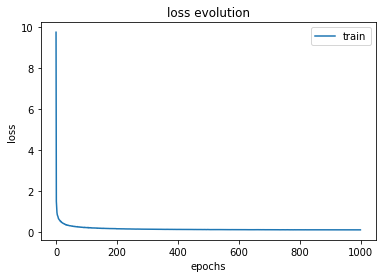

In [63]:
#model.main_train(dataset, training_epochs=200, batch_size=20, verbose=False,callbacks=[tensorboard])
out_batch = NEpochLogger(display=50)
model.main_train(dataset, training_epochs=1000, batch_size=20, verbose=False,callbacks=[tensorboard,out_batch])

#visualizer = LatentSpaceVisualizer(model_folder_path=model_path, dataset_path=labellisation_data_folder + 'sequences_dataset/sequences_et_labels.npz')
 #   visualizer.visualize_embedding_after_training()

In [65]:
with open(os.path.join(path_out,name_model,"config.txt"),'w') as file: 
    file.write(str(cond_pre_dim) + '\n')
    file.write(str(to_emb_dim) + '\n')
    file.write(str(e_dims) + '\n') 
    file.write(str(d_dims) + '\n') 
    file.write(str(z_dim) + '\n')
    file.write(str(beta) + '\n')

In [66]:
#sauvegarde du dataset associé
name_dataset = 'dataset.pickle'

with open( os.path.join(path_out,name_model, name_dataset), "wb" ) as file:
    pickle.dump( dataset, file )

## Loading model 

In [67]:
model.load_model(os.path.join(path_out, name_model, 'models'))

### Analysis of the latent space

In [68]:
name_set_plot = 'train'
version = '-v1'
nPoints=1500

In [69]:
temp_emb = model.embedding.predict(dataset['train']['x'][2])
cond_pre = dataset['train']['x'][1]
cond_emb = model.embedding.predict(dataset['train']['x'][2])
cond = np.concatenate((cond_pre, cond_emb), axis=1)

#cond  = dataset['train']['x'][1]
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond]

In [70]:
cond_emb.shape

(1830, 4)

In [71]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])

In [74]:
log_dir=path_main_folder+"/notebooks/logs/projector_Conso_WeekDay_Temp_4couches"
os.makedirs(log_dir)

FileExistsError: [Errno 17] File exists: '/home/restor/partage/apogee-parades/AED_autoencoder/notebooks/logs/projector_Conso_WeekDay_Temp_4couches'

In [73]:
import os,cv2
images=createLoadProfileImages(x,x_hat,nPoints)

<Figure size 432x288 with 0 Axes>

In [75]:

sprites=images_to_sprite(images)
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes.png'), sprites)

True

In [76]:

x_reduced=x_encoded[0:nPoints,]
writeMetaData(log_dir,x_conso,calendar_info,nPoints)
buildProjector(x_reduced,images,log_dir)

## Analyse prédiction de température
On essaie de prédire la température avec les plus proches voisins. Normalement on drevrait etre meilleur que dans l'autoencoder originel et ensuite on devrait etre moins bons une fois la tempréature prise en compte

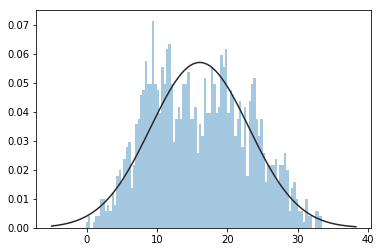

In [77]:
temperatureMax=[max(x_conso.loc[index*48:(index+1)*48-1,'meteo_natTh+0']) for index in range(0,nPoints)]
import seaborn as sn
sn.distplot(temperatureMax, kde=False, fit=stats.norm, bins=100)

In [78]:
from sklearn.neighbors import KNeighborsRegressor
k=5
knn = KNeighborsRegressor(n_neighbors=k)

yTemp=temperatureMax

knn.fit(x_reduced, yTemp)
train_accuracy= knn.score(x_reduced, yTemp)
train_accuracy

0.35923996469813435

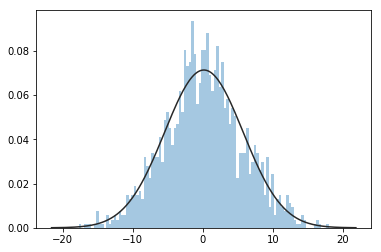

In [79]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_reduced)
error=y_pred-yTemp
sn.distplot(error, kde=False, fit=stats.norm, bins=100)
#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

## classification si espace random


In [80]:
x_reduced_random=np.random.rand(nPoints,1)
knn_random = KNeighborsRegressor(n_neighbors=k)
knn_random.fit(x_reduced_random, yTemp)
train_accuracy_random= knn_random.score(x_reduced_random, yTemp)
train_accuracy_random

0.2028804312965874

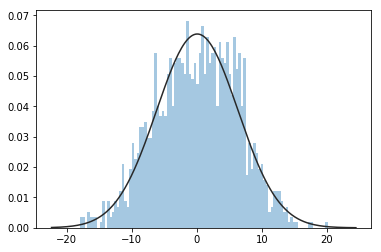

In [81]:
from sklearn.metrics import confusion_matrix
y_pred = knn_random.predict(x_reduced_random)
error=y_pred-yTemp
sn.distplot(error, kde=False, fit=stats.norm, bins=100)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

## Analyse classification de catégorie mois dans espace latent
Normalement on ne devrait plus pouvoir classifier aussi facilement jours de weekend et de semaine dans l'espace projeter

In [84]:
from sklearn.neighbors import KNeighborsClassifier
k=5
knn = KNeighborsClassifier(n_neighbors=k)

yMonth=calendar_info['month']
yMonth=yMonth[0:nPoints,]

knn.fit(x_reduced, yMonth)
train_accuracy= knn.score(x_reduced, yMonth)
train_accuracy

0.47733333333333333

In [87]:
prob=knn.predict_proba(x_reduced)
probScore=[prob[i][yMonth[i]-1] for i in range(0,nPoints) ]

In [88]:
#plutot sous forme d un probability score
sum(probScore)/nPoints

0.3693333333333297

In [90]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_reduced)
confusion_matrix(yMonth,y_pred)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

array([[98,  6, 10,  3,  2,  5,  8,  2, 10,  6,  1,  4],
       [16, 65, 10,  2,  1,  1, 11,  4,  5,  1,  0,  1],
       [20, 26, 52,  4,  4,  0,  4,  1,  7,  4,  0,  2],
       [19,  6,  9, 41,  9,  6,  5,  6,  4,  3,  5,  7],
       [12,  3,  1, 12, 54, 12,  6,  7,  8,  2,  5,  2],
       [11,  2,  1,  6,  9, 79,  1,  2,  5,  1,  0,  3],
       [17, 10,  5,  4,  9, 10, 56,  6,  4,  0,  3,  0],
       [ 6,  4,  3,  5,  9,  2,  5, 77,  6,  0,  3,  4],
       [23,  5,  3,  2,  5, 10,  1,  0, 64,  3,  4,  0],
       [ 9, 10,  7,  0,  9,  5,  9, 10, 14, 43,  4,  4],
       [16,  3,  5,  4, 12, 10,  4,  5,  5, 11, 39,  6],
       [14,  4,  6, 12,  9,  9,  3,  8,  2,  5,  8, 48]])

## classification si espace random


In [91]:
x_reduced_random=np.random.rand(nPoints,1)
knn_random = KNeighborsClassifier(n_neighbors=k)
knn_random.fit(x_reduced_random, yMonth)
train_accuracy_random= knn_random.score(x_reduced_random, yMonth)
train_accuracy_random

0.3413333333333333

In [93]:
prob_random=knn_random.predict_proba(x_reduced_random)
probScore_random=[prob_random[i][yMonth[i]-1] for i in range(0,nPoints) ]


In [94]:
#plutot sous forme d un probability score
sum(probScore_random)/nPoints

0.26359999999999384

In [95]:
from sklearn.metrics import confusion_matrix
y_pred_random = knn_random.predict(x_reduced_random)
confusion_matrix(yMonth,y_pred_random)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

array([[108,   3,   2,   7,   6,   6,   3,   1,   3,   5,   5,   6],
       [ 26,  58,   3,   4,   2,   1,   6,   3,   7,   3,   2,   2],
       [ 31,  18,  46,   3,   2,   2,   2,   4,   3,   5,   4,   4],
       [ 26,  14,  10,  42,   4,   4,   6,   4,   1,   2,   2,   5],
       [ 28,  17,  12,   7,  37,   3,   5,   4,   2,   4,   1,   4],
       [ 29,  12,   8,   7,   6,  32,   8,   2,   4,   4,   4,   4],
       [ 24,  17,  13,  10,   3,   3,  41,   1,   3,   0,   3,   6],
       [ 32,  17,  15,   7,   8,   4,   4,  26,   6,   1,   2,   2],
       [ 26,  11,  14,   5,  12,   4,   9,   6,  25,   3,   1,   4],
       [ 21,  18,  12,   7,   3,   7,  10,   3,   2,  29,   5,   7],
       [ 19,  21,  15,  11,   8,   2,   3,   4,   1,   5,  24,   7],
       [ 29,  13,   8,   9,   4,   5,   3,   3,   4,   4,   2,  44]])

# Creer le dataset de l'autoencodeur 1 - weekday + temperature + mois


In [96]:
# Split train and test
#date_test_start = datetime.date(2014,1,1)
#date_test_end = datetime.date(2015,1,1)
#dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)

dict_xconso = {'train': x_conso}

In [97]:
# Normalize x_conso
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [98]:
name_type_cond = 'm-wd-temp'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c'
type_x = ['conso']
type_cond = ['weekday','temperature','month']#normalement is ne va pas chercher quel jour de la semaine, mais si c'est un jour weekend ou semaine ['weekday', 'temperature']

In [99]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond, slidingWindowSize=0)

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:387: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:390: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:482: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:488: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [100]:
name_set_plot = 'train'
version = '-v1'
nPoints=1500

In [101]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

In [102]:
# modify dataset to fit with new data format
#Pass a constant vector for conditions
nPoints=dataset['train']['x'][1].shape[0]
cond_pre =dataset['train']['x'][1][:,:1]#[0] #dataset['train']['x'][1][:,:14] #les dimensions pour les conditions sans embeddings préalable
#to_emb=dataset['train']['x'][1][:,1:]
#cond_pre =dataset['train']['x'][1][:,:]
#cond_pre=np.zeros((nPoints,1))
to_emb=dataset['train']['x'][1][:,1:]
x = dataset['train']['x'][0]

dataset['train']['x'] = [x, cond_pre, to_emb]

### Build model

In [103]:
#on sauvegarde le dataset
path_out = os.path.join(path_main_folder, 'out')

In [104]:
# Parameters
e_dims=[48,35,24,12]#[24,12]#[48,40,30,20,14,8]
d_dims=[48,35,24,12]#[12,24]#[48,40,30,20,14,8]
to_emb_dim=dataset['train']['x'][2].shape[1]
cond_pre_dim = 1#dataset['train']['x'][1].shape[1]
input_dim = dataset['train']['x'][0].shape[1]
z_dim= 5
beta = 0.01 #0.1 pour une granularite 48

In [105]:
name_model = 'cvae_conso_WeekDay_EmbTemp-30min-journalier'.format(name_granu,name_type_x, name_type_cond)
#name_model = 'cvae_classification'

In [106]:
model = CVAE_temp(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_pre_dim=cond_pre_dim,
                  z_dim=z_dim, 
                  beta=beta,
                  name=name_model, 
                  output=path_out,
                 to_emb_dim=to_emb_dim,
                 emb_dims=[8,4])

2
3
0
1
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
to_emb (InputLayer)             (None, 60)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Model)               (None, 4)            524         to_emb[0][0]                     
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
____________________________________________________________________________________

### Trainning model 

In [107]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)
#os.path.join(path_out,name_model)

 #tensorboard = TensorBoard(log_dir=model_path,write_graph=True,write_images=True)



--- START TRAINING ---

0 Epochs ...  - loss: 9.3697 - kl_loss: 9.0511 - recon_loss: 9.2792
50 Epochs ...  - loss: 0.3349 - kl_loss: 12.9934 - recon_loss: 0.2050
100 Epochs ...  - loss: 0.2251 - kl_loss: 9.4294 - recon_loss: 0.1308
150 Epochs ...  - loss: 0.1846 - kl_loss: 8.0935 - recon_loss: 0.1036
200 Epochs ...  - loss: 0.1537 - kl_loss: 7.1621 - recon_loss: 0.0821
250 Epochs ...  - loss: 0.1433 - kl_loss: 6.8004 - recon_loss: 0.0753
300 Epochs ...  - loss: 0.1347 - kl_loss: 6.4861 - recon_loss: 0.0698
350 Epochs ...  - loss: 0.1285 - kl_loss: 6.2199 - recon_loss: 0.0663
400 Epochs ...  - loss: 0.1235 - kl_loss: 6.2423 - recon_loss: 0.0611
450 Epochs ...  - loss: 0.1193 - kl_loss: 6.0495 - recon_loss: 0.0588
500 Epochs ...  - loss: 0.1180 - kl_loss: 5.9755 - recon_loss: 0.0582
550 Epochs ...  - loss: 0.1156 - kl_loss: 5.9152 - recon_loss: 0.0565
600 Epochs ...  - loss: 0.1156 - kl_loss: 5.9052 - recon_loss: 0.0565
650 Epochs ...  - loss: 0.1115 - kl_loss: 5.7811 - recon_loss: 0.0

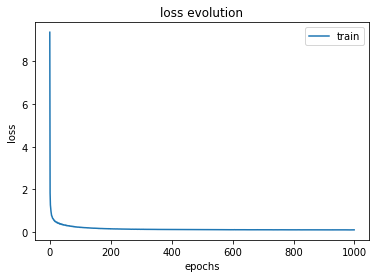

In [108]:
#model.main_train(dataset, training_epochs=200, batch_size=20, verbose=False,callbacks=[tensorboard])
out_batch = NEpochLogger(display=50)
model.main_train(dataset, training_epochs=1000, batch_size=20, verbose=False,callbacks=[tensorboard,out_batch])

#visualizer = LatentSpaceVisualizer(model_folder_path=model_path, dataset_path=labellisation_data_folder + 'sequences_dataset/sequences_et_labels.npz')
 #   visualizer.visualize_embedding_after_training()

In [109]:
with open(os.path.join(path_out,name_model,"config.txt"),'w') as file: 
    file.write(str(cond_pre_dim) + '\n')
    file.write(str(to_emb_dim) + '\n')
    file.write(str(e_dims) + '\n') 
    file.write(str(d_dims) + '\n') 
    file.write(str(z_dim) + '\n')
    file.write(str(beta) + '\n')

In [110]:
#sauvegarde du dataset associé
name_dataset = 'dataset.pickle'

with open( os.path.join(path_out,name_model, name_dataset), "wb" ) as file:
    pickle.dump( dataset, file )

## Loading model 

In [111]:
model.load_model(os.path.join(path_out, name_model, 'models'))

### Analysis of the latent space

In [112]:
name_set_plot = 'train'
version = '-v1'
nPoints=1500

In [113]:
temp_emb = model.embedding.predict(dataset['train']['x'][2])
cond_pre = dataset['train']['x'][1]
cond_emb = model.embedding.predict(dataset['train']['x'][2])
cond = np.concatenate((cond_pre, cond_emb), axis=1)

#cond  = dataset['train']['x'][1]
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond]

In [114]:
cond_emb.shape

(1830, 4)

In [115]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])

In [116]:
log_dir=path_main_folder+"/notebooks/logs/projector_Conso_WeekDay_Temp_Month_4couches"
os.makedirs(log_dir)

In [117]:
import os,cv2
images=createLoadProfileImages(x,x_hat,nPoints)

<Figure size 432x288 with 0 Axes>

In [118]:

sprites=images_to_sprite(images)
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes.png'), sprites)

True

In [119]:

x_reduced=x_encoded[0:nPoints,]
writeMetaData(log_dir,x_conso,calendar_info,nPoints)
buildProjector(x_reduced,images,log_dir)

## Analyse prédiction de température
On essaie de prédire la température avec les plus proches voisins. Normalement on drevrait etre meilleur que dans l'autoencoder originel et ensuite on devrait etre moins bons une fois la tempréature prise en compte

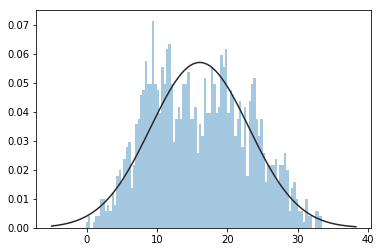

In [120]:
temperatureMax=[max(x_conso.loc[index*48:(index+1)*48-1,'meteo_natTh+0']) for index in range(0,nPoints)]
import seaborn as sn
sn.distplot(temperatureMax, kde=False, fit=stats.norm, bins=100)

In [121]:
from sklearn.neighbors import KNeighborsRegressor
k=5
knn = KNeighborsRegressor(n_neighbors=k)

yTemp=temperatureMax

knn.fit(x_reduced, yTemp)
train_accuracy= knn.score(x_reduced, yTemp)
train_accuracy

0.4450669914692317

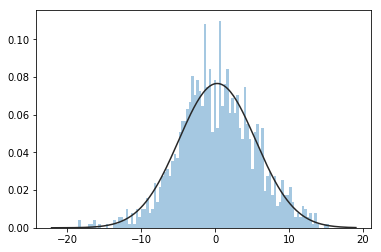

In [122]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_reduced)
error=y_pred-yTemp
sn.distplot(error, kde=False, fit=stats.norm, bins=100)
#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

## classification si espace random


In [123]:
x_reduced_random=np.random.rand(nPoints,1)
knn_random = KNeighborsRegressor(n_neighbors=k)
knn_random.fit(x_reduced_random, yTemp)
train_accuracy_random= knn_random.score(x_reduced_random, yTemp)
train_accuracy_random

0.19029450916631097

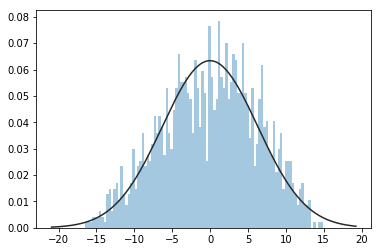

In [124]:
from sklearn.metrics import confusion_matrix
y_pred = knn_random.predict(x_reduced_random)
error=y_pred-yTemp
sn.distplot(error, kde=False, fit=stats.norm, bins=100)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

## Analyse classification de catégorie mois dans espace latent
Normalement on ne devrait plus pouvoir classifier aussi facilement jours de weekend et de semaine dans l'espace projeter

In [125]:
from sklearn.neighbors import KNeighborsClassifier
k=5
knn = KNeighborsClassifier(n_neighbors=k)

yMonth=calendar_info['month']
yMonth=yMonth[0:nPoints,]

knn.fit(x_reduced, yMonth)
train_accuracy= knn.score(x_reduced, yMonth)
train_accuracy

0.43333333333333335

In [126]:
prob=knn.predict_proba(x_reduced)
probScore=[prob[i][yMonth[i]-1] for i in range(0,nPoints) ]

In [127]:
#plutot sous forme d un probability score
sum(probScore)/nPoints

0.3275999999999943

In [128]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_reduced)
confusion_matrix(yMonth,y_pred)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

array([[117,   7,   4,   5,   2,   3,   1,   6,   2,   2,   4,   2],
       [ 21,  57,   4,   6,   5,   3,   4,   3,   3,   3,   2,   6],
       [ 24,  10,  52,   3,   4,   8,   4,   6,   2,   7,   2,   2],
       [ 16,   8,  10,  58,   2,   5,   5,   2,   0,   6,   4,   4],
       [ 15,   8,  11,   9,  39,   6,   4,   8,  10,   4,   3,   7],
       [  8,  10,   6,   5,   7,  64,   7,   4,   5,   0,   1,   3],
       [  9,  13,   6,  11,   7,  16,  40,   7,  10,   0,   3,   2],
       [  7,   1,  12,  10,   8,   6,   7,  62,   6,   2,   1,   2],
       [ 11,  13,   4,   6,   7,  11,   7,   5,  51,   2,   2,   1],
       [ 15,  14,  14,   8,   7,   8,   4,   6,   5,  35,   4,   4],
       [ 19,  10,   7,   7,   3,  13,   5,   8,   4,   2,  33,   9],
       [ 28,  14,   9,   5,   9,   1,   6,   2,   6,   2,   4,  42]])

## classification si espace random


In [129]:
x_reduced_random=np.random.rand(nPoints,1)
knn_random = KNeighborsClassifier(n_neighbors=k)
knn_random.fit(x_reduced_random, yMonth)
train_accuracy_random= knn_random.score(x_reduced_random, yMonth)
train_accuracy_random

0.328

In [130]:
prob_random=knn_random.predict_proba(x_reduced_random)
probScore_random=[prob_random[i][yMonth[i]-1] for i in range(0,nPoints) ]


In [131]:
#plutot sous forme d un probability score
sum(probScore_random)/nPoints

0.26373333333332727

In [132]:
from sklearn.metrics import confusion_matrix
y_pred_random = knn_random.predict(x_reduced_random)
confusion_matrix(yMonth,y_pred_random)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

array([[99,  5,  7, 10,  8,  1,  6,  6,  3,  5,  3,  2],
       [23, 51,  4,  6,  6,  2,  3,  8,  4,  1,  7,  2],
       [33, 11, 45,  4,  4,  5,  5,  2,  1,  6,  4,  4],
       [22, 14, 11, 46,  4,  4,  1,  4,  2,  5,  3,  4],
       [26, 18, 12, 11, 35,  0,  6,  1,  6,  4,  3,  2],
       [26, 15, 12,  5, 10, 28,  2,  9,  1,  6,  3,  3],
       [27, 18,  8,  9,  5,  6, 37,  5,  4,  3,  1,  1],
       [24, 15, 12,  9,  2,  5,  6, 42,  1,  3,  2,  3],
       [27, 12, 14, 14,  2,  6,  8,  5, 22,  6,  1,  3],
       [22, 16, 14, 12,  4,  4,  5,  4,  5, 32,  0,  6],
       [32, 14, 12,  9,  4,  6,  4,  3,  3,  6, 24,  3],
       [27, 17, 10,  7,  8,  2,  8,  7,  3,  5,  3, 31]])